In [54]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.ops import array_ops

from influence.plot_utils import show_graph
from models.ridge_linear_regression import RidgeLinearRegression2Blocks

## Derivation for Ridge Regression
Suppose $x^{1\times p}, X^{n\times p}, y^{n\times 1}, C^{1\times 1}$.
$$
\begin{split}
R_{emp} = \frac{1}{n}((y-X\beta)^{\top} (y-X\beta)+ C\beta^T\beta) \qquad&(1\times 1) \\
\nabla^2_{\beta}R_{emp} = \frac{2}{n}(X^{\top}X +CI_p) \qquad&(p\times p)
\end{split}
$$
For some fixed validation or training point $z = (x,y)$
$$
\begin{split}
L(z;\hat{\beta}) = (y-x\hat{\beta})^{\top} (y-x\hat{\beta})+C\beta^T\beta \qquad&(1\times 1)\\
\nabla_{\beta}L(z;\hat{\beta}) = -2x^{\top} (y-x\hat{\beta})+2C\hat{\beta}\qquad&(p\times 1)\\
p = (\nabla^2_{\beta}R_{emp})^{-1}\nabla_{\beta}L(z_{te};\hat{\beta})\qquad&(p\times 1), \text{ Hessian-vector product}\\
u := \nabla_{\beta}L(z_{tr})=-2x_{tr}^{\top}(y_{tr}-x_{tr}\hat{\beta})+2C\hat{\beta} \qquad&(1\times p), \text{ Gradient of loss of 1 training point}\\
\mathcal{I}_{loss}(\color{red}{z_{tr}}, \color{blue}{z_{te}}) = u^{\top}p = 2n\color{red}{(y_{tr}-x_{tr}\hat{\beta} + C\hat{\beta})^{\top}x_{tr}}(X^{\top}X + 2C)^{-1}\color{blue}{x_{te}^{\top}(y_{te}-x_{te}\hat{\beta}-2C\hat{\beta})}\qquad&(1\times 1)
\end{split}
$$

In [55]:
df = pd.read_csv('data/lm_10.csv')
n = len(df)
X = df.values[:, 0:10]
y = df.values[:, -1].reshape(n, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)
n, p = X_train.shape

(80, 10)
(20, 10)
(80, 1)
(20, 1)


In [56]:
def I_loss_closed_form(X_tr, Y_tr, X_te, Y_te, C):
    n_tr, p = X_tr.shape
    n_te, _ = X_te.shape
    beta_hat = np.linalg.inv(
        X_tr.T.dot(X_tr) + C*np.eye(p)).dot(X_tr.T).dot(Y_tr)
    H_inv = (n_tr/2)*np.linalg.inv((X_tr.T.dot(X_tr)) + C*np.eye(p))
    I_loss = np.zeros((n_tr, n_te))
    for i in range(n_tr):
        for j in range(n_te):
            x_tr, y_tr = X_tr[i:i+1,:], Y_tr[i:i+1,:]
            x_te, y_te = X_te[j:j+1,:], Y_te[j:j+1,:]
            grad_tr = -2*x_tr.T.dot(y_tr - x_tr.dot(beta_hat)) + 2*C*beta_hat
            grad_te = -2*x_te.T.dot(y_te - x_te.dot(beta_hat)) + 2*C*beta_hat
            I_loss[i,j] = grad_tr.T.dot(H_inv).dot(grad_te)
    return I_loss

regularization = 1.
I_loss_cf = I_loss_closed_form(X_train, y_train, X_test, y_test, regularization)

In [57]:
tf.reset_default_graph()
model = RidgeLinearRegression2Blocks(
    model_name='RidgeLinearRegression2Blocks',
    eta=0.01, C = regularization)
model.fit(X_train, y_train, n_iter=10000)

Step 0: loss = 151.12817383 (0.047 sec)
Step 1000: loss = 72.36564636 (0.000 sec)
Step 2000: loss = 72.36564636 (0.000 sec)
Step 3000: loss = 72.36564636 (0.000 sec)
Step 4000: loss = 72.36564636 (0.000 sec)
Step 5000: loss = 72.36564636 (0.000 sec)
Step 6000: loss = 72.36564636 (0.000 sec)
Step 7000: loss = 72.36564636 (0.000 sec)
Step 8000: loss = 72.36564636 (0.000 sec)
Step 9000: loss = 72.36564636 (0.000 sec)


RidgeLinearRegression2Blocks(C=1.0)

In [59]:
#show_graph(tf.get_default_graph())

In [60]:
%%time
I_loss_bf = model.influence_loss(
    X_test, y_test, method='brute-force')

Fetch training loss gradients (0.126 sec)
CPU times: user 295 ms, sys: 21.7 ms, total: 316 ms
Wall time: 290 ms


In [61]:
abs_pct_error = 100*np.abs(
    I_loss_bf - I_loss_cf) / np.abs(I_loss_cf)
print("Absolute percentage error to closed form:")
for row in abs_pct_error:
    print([('%.3f' % x) + '%' for x in row])

Absolute percentage error to closed form:
['125.674%', '84.186%', '140.026%', '89.382%', '26.807%', '110.718%', '120.871%', '107.729%', '66.127%', '185.152%', '160.416%', '112.909%', '115.098%', '365.824%', '89.743%', '128.182%', '133.926%', '96.929%', '121.324%', '138.571%']
['112.603%', '62.252%', '125.843%', '92.145%', '59.508%', '138.469%', '125.640%', '73.414%', '54.431%', '135.679%', '34.701%', '225.105%', '140.214%', '276.447%', '60.331%', '83.661%', '177.256%', '68.245%', '104.002%', '31.469%']
['98.775%', '138.487%', '130.034%', '121.831%', '84.689%', '106.010%', '76.311%', '54.381%', '133.285%', '91.237%', '75.758%', '4.441%', '95.075%', '16.321%', '137.834%', '88.854%', '142.100%', '80.701%', '93.823%', '84.300%']
['88.285%', '104.583%', '90.124%', '97.484%', '158.702%', '96.769%', '95.234%', '90.976%', '103.378%', '82.092%', '125.381%', '136.442%', '93.114%', '167.874%', '153.902%', '90.658%', '137.568%', '91.130%', '89.090%', '88.885%']
['105.663%', '44.122%', '120.327%', 

## Test Against LOO

In [37]:
%%time
I_loss_loo = model.leave_one_out_refit(
    X_test, y_test, n_iter=1000)

LOO Fold 0: loss = 71.83039093 (0.446 sec)
LOO Fold 8: loss = 72.36277771 (0.449 sec)
LOO Fold 16: loss = 72.52394867 (0.434 sec)
LOO Fold 24: loss = 72.56778717 (0.447 sec)
LOO Fold 32: loss = 72.71797180 (0.454 sec)
LOO Fold 40: loss = 72.81506348 (0.481 sec)
LOO Fold 48: loss = 72.64910889 (0.429 sec)
LOO Fold 56: loss = 72.08290100 (0.524 sec)
LOO Fold 64: loss = 72.73323059 (0.443 sec)
LOO Fold 72: loss = 72.56803131 (0.432 sec)
CPU times: user 52.7 s, sys: 8.19 s, total: 1min
Wall time: 38.4 s


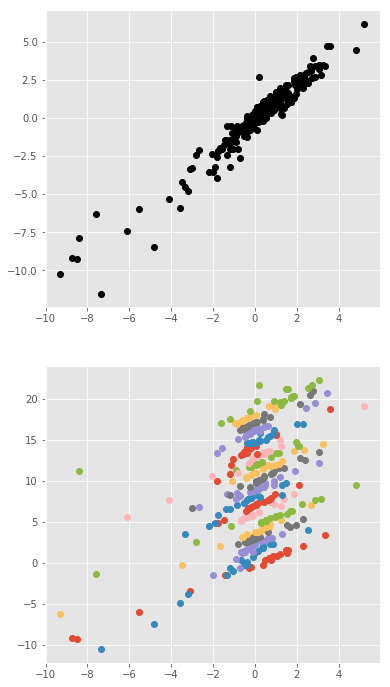

In [39]:
fig, axes = plt.subplots(2, 1,figsize=(6,12))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:], 
                 'o', color='black')
    axes[1].plot(I_loss_bf[j,:]/(-n_tr), I_loss_loo[j,:]+j, 'o')

## Conjugate GD Approximation

In [30]:
%%time
I_loss_cg = model.influence_loss(
    X_test, y_test, method='cg')

Fetch training loss gradients (0.056 sec)
CG Objective: -11.709106
CG Objective: -21.051456
CG Objective: -21.114351
CG Objective: -21.114864
CG Objective: -21.11487
         Current function value: -21.114870
         Iterations: 5
         Function evaluations: 82
         Gradient evaluations: 77
         Hessian evaluations: 7
CG Objective: -87.53711
CG Objective: -184.42876
CG Objective: -185.0553
CG Objective: -185.05965
CG Objective: -185.05975
CG Objective: -185.05975
         Current function value: -185.059753
         Iterations: 6
         Function evaluations: 71
         Gradient evaluations: 76
         Hessian evaluations: 9
CG Objective: -19.119778
CG Objective: -30.922955
CG Objective: -30.97997
CG Objective: -30.980347
CG Objective: -30.980352
         Current function value: -30.980352
         Iterations: 5
         Function evaluations: 79
         Gradient evaluations: 72
         Hessian evaluations: 7
CG Objective: -58.053062
CG Objective: -85.876686
CG Objecti

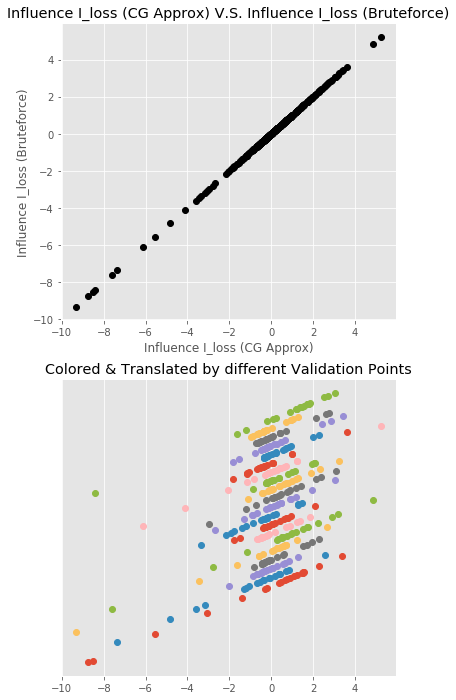

In [31]:
fig, axes = plt.subplots(2, 1,figsize=(6,12))
n_tr, _ = X_train.shape
n_te, _ = X_test.shape

for j in range(n_te):
    axes[0].plot(I_loss_cg[j,:]/(-n_tr), I_loss_bf[j,:]/(-n_tr), 
                 'o', color='black')
    
    axes[1].plot(I_loss_cg[j,:]/(-n_tr), I_loss_bf[j,:]/(-n_tr)+j, 'o')

axes[0].update({
    'title':'Influence I_loss (CG Approx) V.S. Influence I_loss (Bruteforce)',
    'xlabel': 'Influence I_loss (CG Approx)',
    'ylabel': 'Influence I_loss (Bruteforce)'})

_ = axes[1].update({
    'title':'Colored & Translated by different Validation Points',
    'yticks': []})